In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
from PIL import Image

In [2]:
def jpg_to_numpy_pillow(image_path):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image to a numpy array
    img_array = np.array(img)
    return img_array

In [3]:
def sliding_window(image, window_size, stride):
    patches = []
    positions = []
    h, w = image.shape[:2]
    for i in range(0, h - window_size + 1, stride):
        for j in range(0, w - window_size + 1, stride):
            patch = image[i:i + window_size, j:j + window_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions

def reconstruct_from_patches(patches, positions, image_size, window_size, stride):
    reconstructed = np.zeros(image_size)
    patch_count = np.zeros(image_size)
    
    for patch, (i, j) in zip(patches, positions):
        reconstructed[i:i + window_size, j:j + window_size] += patch
        patch_count[i:i + window_size, j:j + window_size] += 1
    
    return reconstructed / patch_count

def visualize_patches(image, window_size, stride):
    fig, ax = plt.subplots(1, figsize=(5,5))
    ax.imshow(image)
    
    patches, positions = sliding_window(image, window_size, stride)

    k = 0
    
    for (i, j) in positions:
        if k%2 == 0:
            rect = mpatches.Rectangle((j, i), window_size, window_size, linewidth=2, edgecolor='r', facecolor='none', alpha=0.5)
        else:
            rect = mpatches.Rectangle((j, i), window_size, window_size, linewidth=2, edgecolor='k', linestyle='--', facecolor='none', alpha=0.5)
        ax.add_patch(rect)
        k = k + 1
    
    plt.title(f'Image with {len(positions)} patches of size {window_size}x{window_size}')
    plt.show()

# Example usage
image = jpg_to_numpy_pillow('data/test_segment.jpg')  # Example large image
print(image.shape)

(480, 640, 3)


In [4]:
window_size = 160
stride = 80  # 50% overlap

chunks, positions = sliding_window(image, window_size, stride)
print('image divided into {} patches, positions array size: {}'.format(len(chunks),len(positions)))

image divided into 35 patches, positions array size: 35


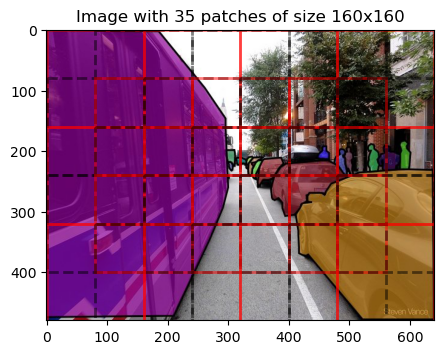

In [5]:
visualize_patches(image, window_size, stride)

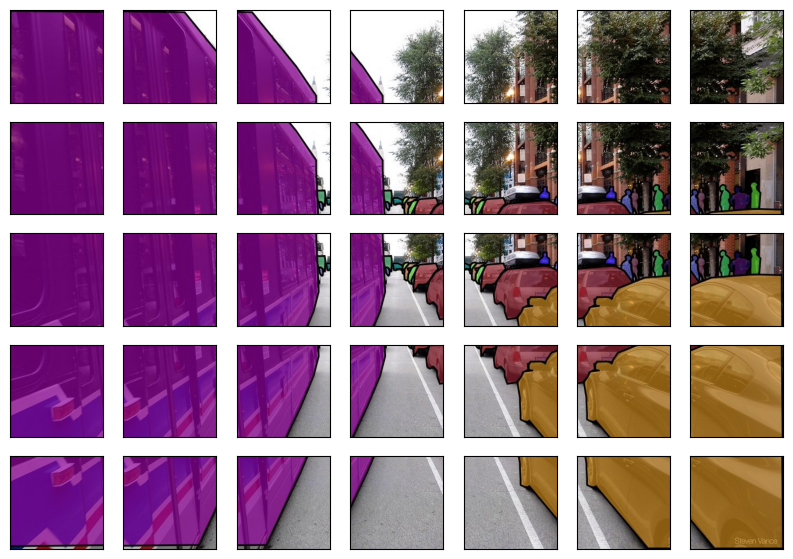

In [6]:
fig, ax = plt.subplots(5,7,figsize=(10,7))
k = 0
for i in range(5):
    for j in range(7):
        ax[i,j].imshow(chunks[k])
        ax[i,j].set_xticks([]); ax[i,j].set_yticks([])
        k = k + 1
plt.show()

# Model design and training

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

2024-06-25 17:01:31.314457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 17:01:31.387012: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on patches (example)
# X_train and Y_train should be the patches and corresponding masks
# model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

2024-06-25 17:03:09.216653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## Prediction: Sliding Window Inference

In [11]:
# Predict on patches
predicted_patches = [model.predict(patch[np.newaxis, ...])[0] for patch in chunks]

# Reconstruct the full segmentation mask
segmented_image = reconstruct_from_patches(predicted_patches, positions, image.shape, window_size, stride)

ValueError: in user code:

    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/srv/conda/envs/ar-goes/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 160, 160, 3)


## Apply CRF

In [14]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

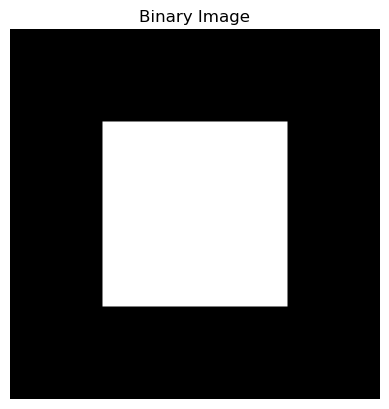

In [15]:

def create_binary_image(height, width):
    # Create an empty black image
    binary_image = np.zeros((height, width), dtype=np.uint8)

    # Draw a white rectangle in the center
    rect_start = (height // 4, width // 4)
    rect_end = (3 * height // 4, 3 * width // 4)
    binary_image[rect_start[0]:rect_end[0], rect_start[1]:rect_end[1]] = 1

    return binary_image

def visualize_binary_image(binary_image):
    plt.imshow(binary_image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')
    plt.show()

# Create a binary image
height = 256
width = 256
binary_image = create_binary_image(height, width)

# Visualize the binary image
visualize_binary_image(binary_image)

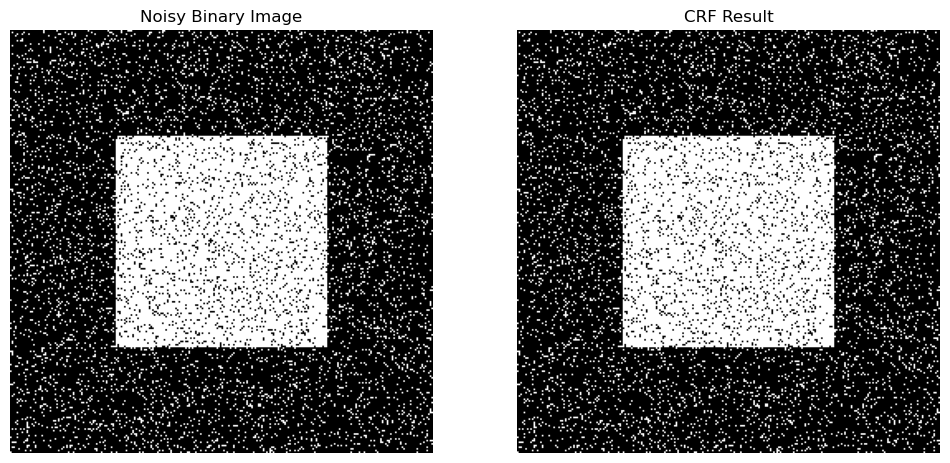

In [24]:
def create_noisy_binary_image(height, width):
    # Create an empty black image
    binary_image = np.zeros((height, width), dtype=np.uint8)
    
    # Draw a white square in the center
    rect_start = (height // 4, width // 4)
    rect_end = (3 * height // 4, 3 * width // 4)
    binary_image[rect_start[0]:rect_end[0], rect_start[1]:rect_end[1]] = 1
    
    # Add more random noise
    noise = np.random.rand(height, width) > 0.90  # Increase the probability of noise
    binary_image[noise] = 1 - binary_image[noise]
    
    return binary_image

def apply_crf(image, predicted_prob):
    h, w = image.shape[:2]
    n_classes = predicted_prob.shape[-1]
    
    d = dcrf.DenseCRF2D(h, w, n_classes)
    
    # Ensure the unary potentials are C-contiguous
    unary = unary_from_softmax(predicted_prob.transpose(2, 0, 1))
    unary = np.ascontiguousarray(unary)
    d.setUnaryEnergy(unary)
    
    # Convert the 2D binary image to a 3D image by stacking it into 3 channels
    image_3d = np.stack([image, image, image], axis=-1)
    
    # Add pairwise Gaussian potentials
    d.addPairwiseGaussian(sxy=(3, 3), compat=3)
    
    # Add pairwise bilateral potentials
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=image_3d, compat=10)
    
    # Perform inference
    Q = d.inference(10)
    
    # Return the final segmentation
    return np.argmax(Q, axis=0).reshape((h, w))

# Create a noisy binary image
height = 256
width = 256
noisy_binary_image = create_noisy_binary_image(height, width)

# Simulate predicted probabilities for binary segmentation
predicted_prob = np.stack([1 - noisy_binary_image, noisy_binary_image], axis=-1).astype(np.float32)

# Apply CRF
crf_result = apply_crf(noisy_binary_image, predicted_prob)

# Visualize the original noisy image and the CRF result
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(noisy_binary_image, cmap='gray')
plt.title('Noisy Binary Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(crf_result, cmap='gray')
plt.title('CRF Result')
plt.axis('off')

plt.show()

(-0.5, 255.5, 255.5, -0.5)

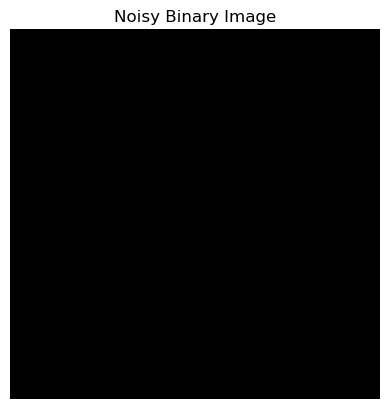

In [25]:
plt.imshow(noisy_binary_image-crf_result, cmap='gray')
plt.title('Noisy Binary Image')
plt.axis('off')